Link to original notebook: https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner/notebook

### TODO:
* Up to date international football matches results:
    * https://github.com/martj42/international_results
* Scrape one of following sits for roster of teams
    * https://www.espn.com/soccer/team/squad/_/id/660/usa
    * https://www.transfermarkt.us/schweiz/startseite/verein/3384
* Learn how to best scrape soccer stats
    * https://python.plainenglish.io/how-to-build-a-football-dataset-with-web-scraping-d4deffcaa9ca 
    * https://minesanalytics.weebly.com/data-resources.html
* Weighted rank over past 5 years
    * https://thepowerrank.com/world-football-soccer/
* Elo Ratings - use for weighted rank (home - away)
    * https://www.eloratings.net/
    * https://www.international-football.net/elo-ratings-table?year=2022&month=06&day=12
    * elo library in R - https://edomt.github.io/Elo-R-WorldCup/
* Tutorial
    * https://www.youtube.com/watch?v=0irmDBWLrco
* Sites for insights into world cup machine learning
    * https://www.kaggle.com/competitions/football-match-probability-prediction/code
* Player ratings (webcrawler) (11 starters + 3 reserves for each country in tournament)
    * https://github.com/4m4n5/fifa18-all-player-statistics/blob/master/crawler.ipynb
* Plater stats from each country:
    * https://www.transfermarkt.com/switzerland/leistungsdaten/verein/3384/plus/1?reldata=%262022
* Algorithms for better results:
    * ANN with backward-propagation
    * Time-dependent Poisson Regression
    * Time-dependent Markov Chain
    * SVM?
    * Time-dependent Markov chaine 
    * Linear Support Vector Classifier?
        * https://towardsdatascience.com/using-machine-learning-to-simulate-world-cup-matches-959e24d0731
* Historical World Cup Stats
    * http://www.rsssf.com/tablesw/worldcup.html
    * http://www.rsssf.com/tablesw/wcq-records.html
    * http://www.planetworldcup.com/STATS/statrecs.html
    * http://www.planetworldcup.com/CUPS/tournaments.html
    * http://wildstat.com/p/40/cht/14/stat/summary

## Goals:
* Predict winners of each world cup game
* Predict winner of World Cup 2022

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

###  matches data set - updated June 19, 2022

In [2]:
## fifa_ranking.csv
rankings = pd.read_csv('fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

## results.csv
matches = pd.read_csv('results.csv')
matches =  matches.replace({'Germany DR': 'Germany'})
matches['date'] = pd.to_datetime(matches['date'])

## World Cup 2018 Dataset
world_cup = pd.read_csv('World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')

## wc2022.iloc[rowStart: rowEnd, columnStart:columnEnd]
ex.
wc2022.iloc[3:5, 2:4]

- senegal    qatar    ecuador

- england    usa      wales

In [3]:
## World Cup 2022 Dataset
wc2022 = pd.read_csv('wc2020.csv')
wc2022 = wc2022.loc[:, ['Team', 'Group', 'first match', 'second match', 'third match']]
wc2022 = wc2022.set_index('Team')

## World Cup 2022 Rankings
rank_2022 = pd.read_csv('2022_rank.csv')
rank_2022 = rank_2022.loc[:,['rank', 'country_full', 'country_abrv', 'total_points', 'weighted']]
rank_2022['weighted_points'] = rank_2022['weighted']

In [4]:
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [5]:
matches['home_score'].mean()

1.7401261656609983

In [7]:
matches['away_score'].mean()

1.180128908392759

In [8]:
1.740 + 1.1801

2.9200999999999997

In [9]:
2.9200999999999997 * 64

186.88639999999998

In [5]:
rank_2022['rank'] = rank_2022['rank'].astype(float)

In [6]:
rank_2022.dtypes

rank               float64
country_full        object
country_abrv        object
total_points       float64
weighted           float64
weighted_points    float64
dtype: object

## Feature extraction

I join the matches with the ranks of the different teams.

Then extract some features:
* point and rank differences
* if the game was for some stakes, because my naive view was that typically friendly matches are harder to predict (TODO differentiate the WC matches from the rest)
* how many days the different teams were able to rest but this turned out to be not important enough to be worth the hassle
* include the participant countries as a one hot vector but that did not appear to be a strong predictor either



In [7]:
rankings.head()

,rank,country_full,country_abrv,cur_year_avg_weighted,rank_date,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,1,Germany,GER,0.0,1993-08-08,0.0,0.0,0.0
1,2,Italy,ITA,0.0,1993-08-08,0.0,0.0,0.0
2,3,Switzerland,SUI,0.0,1993-08-08,0.0,0.0,0.0
3,4,Sweden,SWE,0.0,1993-08-08,0.0,0.0,0.0
4,5,Argentina,ARG,0.0,1993-08-08,0.0,0.0,0.0


In [8]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [9]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

# I tried earlier rest days but it did not turn to be useful
max_rest = 30
# matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# I tried earlier the team as well but that did not make a difference either
# matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(wc2022.index.tolist())
# matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
# matches = matches.join(pd.get_dummies(matches['wc_participant']))


## Modeling

I used a simple Logistic regression, which yielded already rather good performance


/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


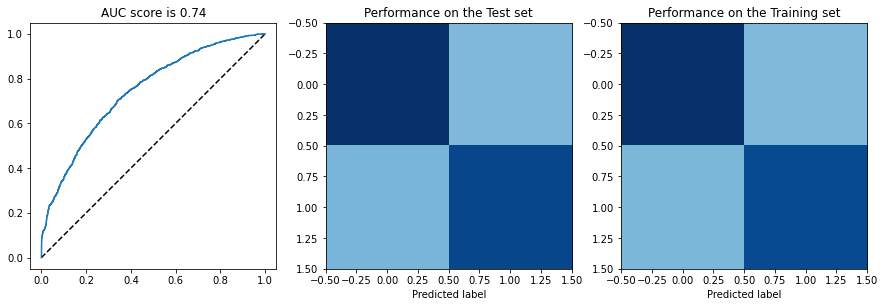

In [10]:

from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass



I consider this pretty good performance, minding that soccer matches have typically only few goals scored and therefore making their outcome even more unpredictable. Nevertheless, let's look at the bad predictions and see where we are making mistakes more often.

Stakes distribution in the wrong predictions
True     0.572414
False    0.427586
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.625266
False    0.374734
Name: is_stake, dtype: float64


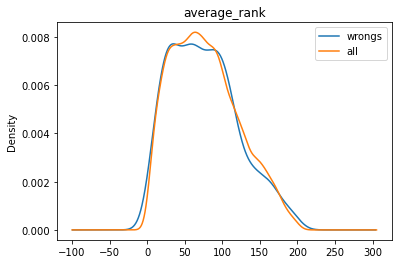

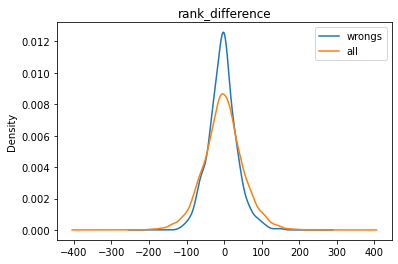

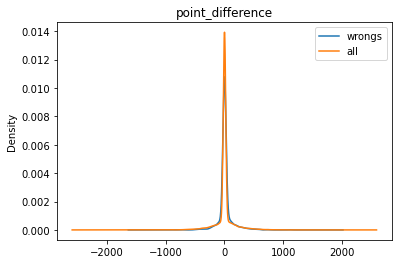

In [11]:
features = ['average_rank', 'rank_difference', 'point_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])


From these figures, we read
* we predict worse for closer ranks
* lower ranks in general
* and somewhat for matches with no stakes (Friendly here)

Luckily, this implies that for the world cup our predicitons may be somewhat even better

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting

In [13]:
# Histogram of column data
def plotHistogram(matches, nHistogramShown, nHistogramPerRow):
    nunique = matches.nunique()
    matches = matches[[col for col in matches if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = matches.shape
    columnNames = list(matches)
    nHistRow = (nCol + nHistogramPerRow - 1) / nHistogramPerRow
    plt.figure(num=None, figsize=(6*nHistogramPerRow, 8*nHistRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nHistogramShown)):
        plt.subplot(nHistRow, nHistogramPerRow, i+1)
        matches.iloc[:,i].hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

In [14]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
#     filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
#     if df.shape[1] < 2:
#         print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
#         return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
#     plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [15]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


/var/folders/j_/555m2zps099832fjh_m8jjnc0000gn/T/ipykernel_70375/769847067.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df.dropna('columns') # drop columns with NaN


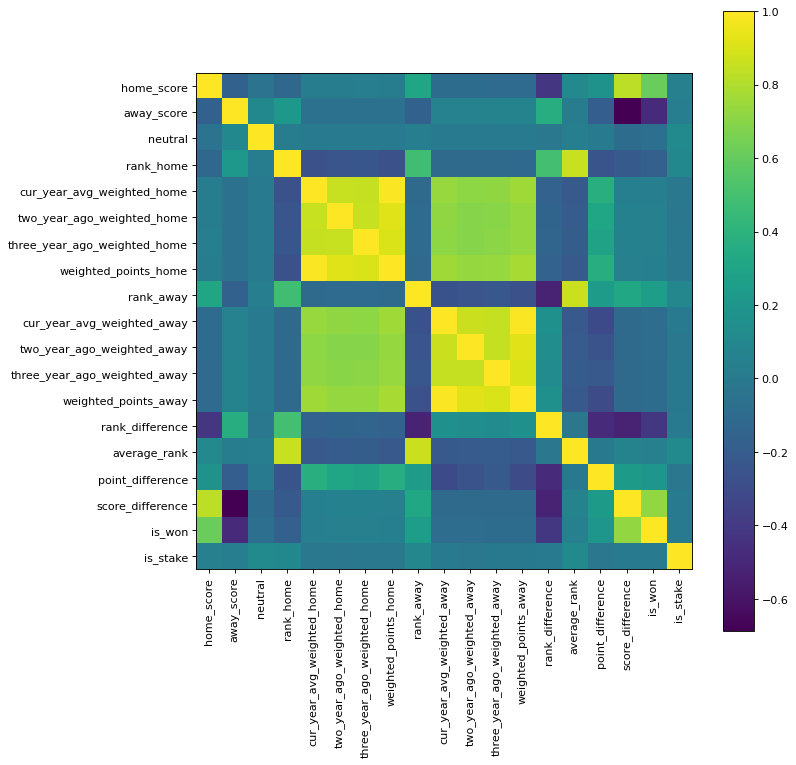

In [16]:
plotCorrelationMatrix(matches, 10)

/var/folders/j_/555m2zps099832fjh_m8jjnc0000gn/T/ipykernel_70375/950191735.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df.dropna('columns')


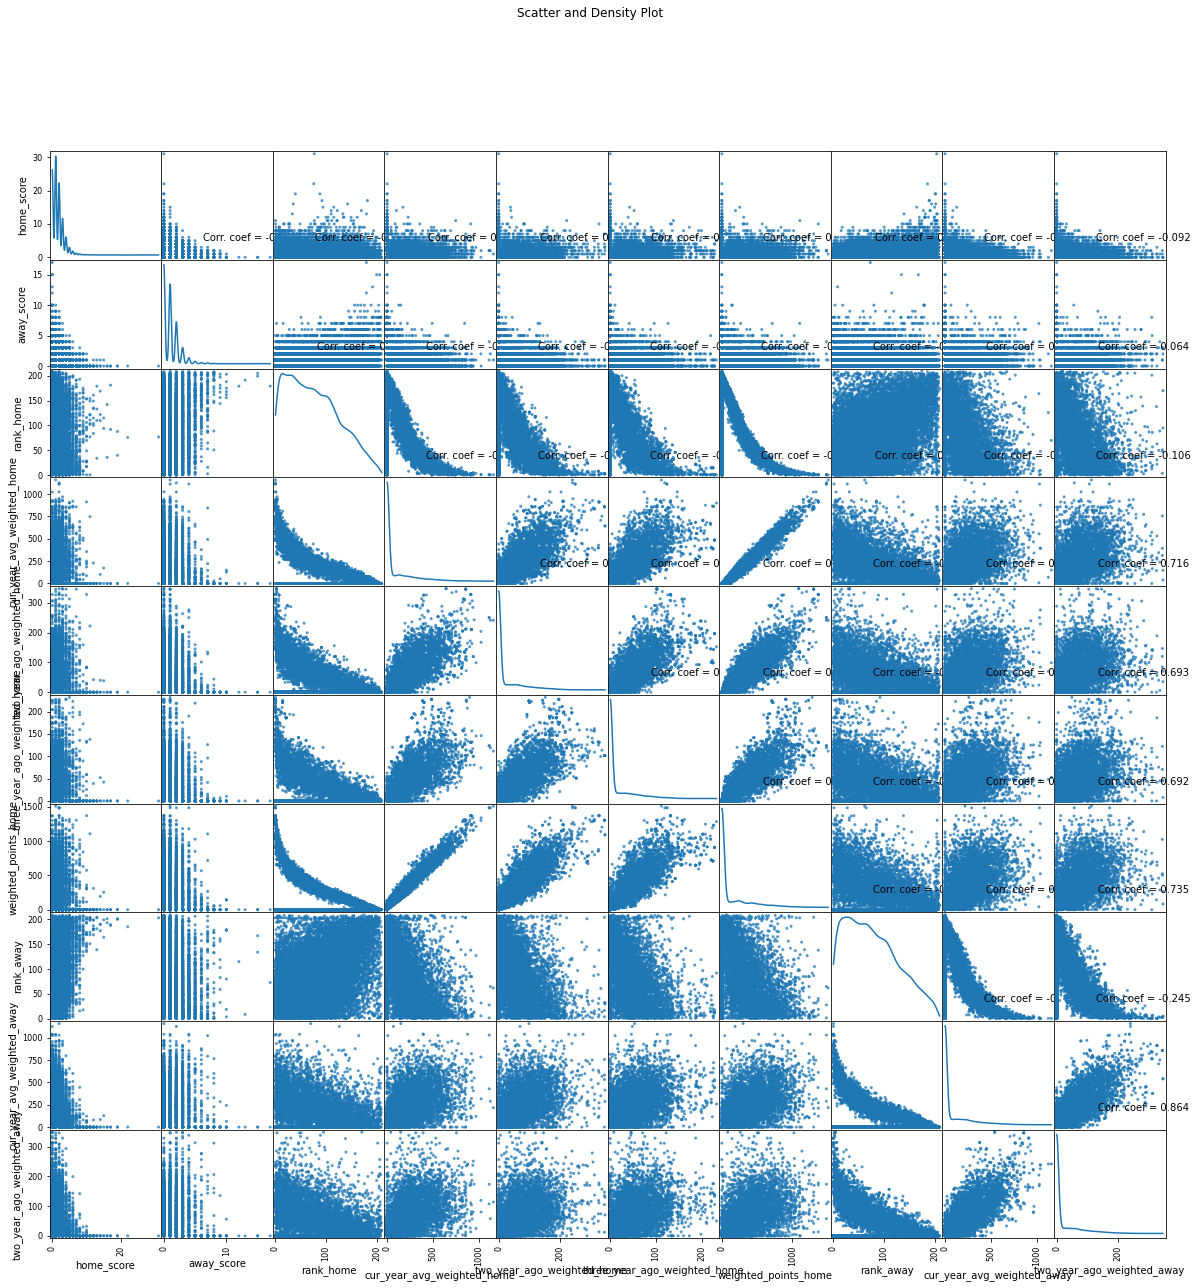

In [17]:
plotScatterMatrix(matches, 20, 10)

## World Cup simulation

### Group rounds

# 2018

In [18]:
# # let's define a small margin when we safer to predict draw then win
# margin = 0.05

# # let's define the rankings at the time of the World Cup
# world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
#                                     rankings['country_full'].isin(world_cup.index.unique())]
# world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [19]:
# from itertools import combinations

# opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

# world_cup['points'] = 0
# world_cup['total_prob'] = 0

# for group in set(world_cup['Group']):
#     print('___Starting group {}:___'.format(group))
#     for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
#         print("{} vs. {}: ".format(home, away), end='')
#         row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
#         home_rank = world_cup_rankings.loc[home, 'rank']
#         home_points = world_cup_rankings.loc[home, 'weighted_points']
#         opp_rank = world_cup_rankings.loc[away, 'rank']
#         opp_points = world_cup_rankings.loc[away, 'weighted_points']
#         row['average_rank'] = (home_rank + opp_rank) / 2
#         row['rank_difference'] = home_rank - opp_rank
#         row['point_difference'] = home_points - opp_points
        
#         home_win_prob = model.predict_proba(row)[:,1][0]
#         world_cup.loc[home, 'total_prob'] += home_win_prob
#         world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
#         points = 0
#         if home_win_prob <= 0.5 - margin:
#             print("{} wins with {:.2f}".format(away, 1-home_win_prob))
#             world_cup.loc[away, 'points'] += 3
#         if home_win_prob > 0.5 - margin:
#             points = 1
#         if home_win_prob >= 0.5 + margin:
#             points = 3
#             world_cup.loc[home, 'points'] += 3
#             print("{} wins with {:.2f}".format(home, home_win_prob))
#         if points == 1:
#             print("Draw")
#             world_cup.loc[home, 'points'] += 1
#             world_cup.loc[away, 'points'] += 1

# 2022

In [20]:
# # let's define a small margin when we safer to predict draw then win
# margin = 0.05

# # let's define the rankings at the time of the World Cup
# world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
#                                     rankings['country_full'].isin(world_cup.index.unique())]
# world_cup_rankings = world_cup_rankings.set_index(['country_full'])



In [21]:
# wc2022_rankings = pd.read_csv('2022_rank.csv')

In [22]:
# wc2022_rankings['rank_date'] = '2022/01/01'


In [23]:
# rank_2022

In [26]:
rank_2022.head()

,rank,country_full,country_abrv,total_points,weighted,weighted_points
0,1.0,Brazil,BRA,1832.69,2.44,2.44
1,2.0,Belgium,BEL,1827.00,2.37,2.37
2,3.0,France,FRA,1789.85,2.22,2.22
3,4.0,Argentina,ARG,1765.13,1.91,1.91
4,5.0,England,ENG,1761.71,2.04,2.04


In [29]:
rank_2022['rank_date'] = '2022/01/01'

In [30]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
wc2022_rankings = rank_2022.loc[(rankings['rank_date'] == rank_2022['rank_date'].max()) & 
                                    rank_2022['country_full'].isin(wc2022.index.unique())]
wc2022_rankings = wc2022_rankings.set_index(['country_full'])

In [ ]:
# from itertools import combinations

# opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

# world_cup['points'] = 0
# world_cup['total_prob'] = 0

# for group in set(world_cup['Group']):
#     print('___Starting group {}:___'.format(group))
#     for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
#         print("{} vs. {}: ".format(home, away), end='')
#         row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
#         home_rank = world_cup_rankings.loc[home, 'rank']
#         home_points = world_cup_rankings.loc[home, 'weighted_points']
#         opp_rank = world_cup_rankings.loc[away, 'rank']
#         opp_points = world_cup_rankings.loc[away, 'weighted_points']
#         row['average_rank'] = (home_rank + opp_rank) / 2
#         row['rank_difference'] = home_rank - opp_rank
#         row['point_difference'] = home_points - opp_points
        
#         home_win_prob = model.predict_proba(row)[:,1][0]
#         world_cup.loc[home, 'total_prob'] += home_win_prob
#         world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
#         points = 0
#         if home_win_prob <= 0.5 - margin:
#             print("{} wins with {:.2f}".format(away, 1-home_win_prob))
#             world_cup.loc[away, 'points'] += 3
#         if home_win_prob > 0.5 - margin:
#             points = 1
#         if home_win_prob >= 0.5 + margin:
#             points = 3
#             world_cup.loc[home, 'points'] += 3
#             print("{} wins with {:.2f}".format(home, home_win_prob))
#         if points == 1:
#             print("Draw")
#             world_cup.loc[home, 'points'] += 1
#             world_cup.loc[away, 'points'] += 1

In [33]:
rank_2022['rank'] = rank_2022['rank'].astype(int)


In [38]:
# rank_2022

In [39]:
from itertools import combinations

opponents = ['first match', 'second match', 'third match']

wc2022['points'] = 0
wc2022['total_prob'] = 0

for group in set(wc2022['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(wc2022.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)

#         ## ERROR FROM WEIGHTED_POINTS -- DONT HAVE DATA FOR WEIGHTED POINTS
#         home_rank = rank_2022.loc[home, 'rank']
#         home_points = rank_2022.loc[home, 'weighted_points']
#         opp_rank = rank_2022.loc[away, 'rank']
#         opp_points = rank_2022.loc[away, 'weighted_points']
        
#         row['average_rank'] = (home_rank + opp_rank) / 2
#         row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        wc2022.loc[home, 'total_prob'] += home_win_prob
        wc2022.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            wc2022.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            wc2022.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            wc2022.loc[home, 'points'] += 1
            wc2022.loc[away, 'points'] += 1


___Starting group F:___
Belgium vs. Canada: 

NameError: name 'home_points' is not defined

## Single-elimination rounds

In [37]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

KeyError: 'points'

## Let's see a visualization

In [ ]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi', args='')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()
